# Proof of concept (estimation for gates, depth)
## Get Groundstate of LiH with VQE, AdaptVqe and StatefulVQE
- taken from: https://qiskit-community.github.io/qiskit-nature/howtos/adapt_vqe.html

In [1]:
# imports
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from qiskit_algorithms import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

import time
from datetime import datetime

## Define problem with ansatz

In [2]:
#driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
#driver = PySCFDriver(atom="C 0 0 -0.6025; H 0 0 -1.6691; C 0 0 0.6025; H 0 0 1.6691", basis="sto-3g")
#driver = PySCFDriver(atom="O 0 0 0; H  0 1 0; H 0 0 1", basis="sto-3g")
driver = PySCFDriver(atom="Li 0 0 0; H 0 0 1.5", basis="sto-3g")
#driver = PySCFDriver(atom="He 0 0 0; He 0 0 0.9", basis="sto-3g")
problem = driver.run()

In [3]:
mapper = JordanWignerMapper()

In [4]:
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

In [5]:
print(problem.num_spatial_orbitals, problem.num_particles, ansatz.width())

6 (2, 2) 12


In [6]:
# define vqe
vqe = VQE(Estimator(), ansatz, SLSQP())
vqe.initial_point = np.zeros(ansatz.num_parameters)

## implement StatefulVQE
- taken over from qiskit-nature-cp2k

In [7]:
# imports
import logging

from enum import Enum

from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.circuit.library import EvolvedOperatorAnsatz

from qiskit_algorithms.list_or_dict import ListOrDict
from qiskit_algorithms import VQEResult

from qiskit_algorithms.observables_evaluator import estimate_observables
from qiskit_algorithms.utils import validate_bounds, validate_initial_point
from qiskit_algorithms.utils.set_batching import _set_default_batchsize

In [8]:
logger = logging.getLogger(__name__)

In [9]:
def depth_filter(param):
    inst, qubits, clbits = param
    return inst.num_qubits == 2

In [10]:
class StatefulVQE(VQE):
    def compute_minimum_eigenvalue(
        self,
        operator: BaseOperator,
        aux_operators: ListOrDict[BaseOperator] | None = None,
    ) -> VQEResult:
        if self.ansatz.num_parameters == 0:
            eigenvalue = estimate_observables(self.estimator, self.ansatz, [operator])[0][0]

            optimizer_result = OptimizerResult()
            optimizer_result.x = []
            optimizer_result.fun = eigenvalue
            optimizer_result.jac = None
            optimizer_result.nfev = 0
            optimizer_result.njev = 0
            optimizer_result.nit = 0

            optimizer_time = 0

            if aux_operators is not None:
                aux_operators_evaluated = estimate_observables(
                    self.estimator,
                    self.ansatz,
                    aux_operators,
                    optimizer_result.x,
                )
            else:
                aux_operators_evaluated = None

            return self._build_vqe_result(
                self.ansatz,
                optimizer_result,
                aux_operators_evaluated,
                optimizer_time,
            )

        self._check_operator_ansatz(operator)

        initial_point = validate_initial_point(self.initial_point, self.ansatz)

        bounds = validate_bounds(self.ansatz)

        start_time = time.time()

        evaluate_energy = self._get_evaluate_energy(self.ansatz, operator)

        if self.gradient is not None:
            evaluate_gradient = self._get_evaluate_gradient(self.ansatz, operator)
        else:
            evaluate_gradient = None

        # perform optimization
        if callable(self.optimizer):
            optimizer_result = self.optimizer(
                fun=evaluate_energy,
                x0=initial_point,
                jac=evaluate_gradient,
                bounds=bounds,
            )
        else:
            # we always want to submit as many estimations per job as possible for minimal
            # overhead on the hardware
            was_updated = _set_default_batchsize(self.optimizer)

            optimizer_result = self.optimizer.minimize(
                fun=evaluate_energy,
                x0=initial_point,
                jac=evaluate_gradient,
                bounds=bounds,
            )

            # reset to original value
            if was_updated:
                self.optimizer.set_max_evals_grouped(None)

        optimizer_time = time.time() - start_time

        logger.info(
            "Optimization complete in %s seconds.\nFound optimal point %s",
            optimizer_time,
            optimizer_result.x,
        )

        # stateful aspect to permit warm-starting of the algorithm
        self.initial_point = optimizer_result.x

        if aux_operators is not None:
            aux_operators_evaluated = estimate_observables(
                self.estimator, self.ansatz, aux_operators, optimizer_result.x
            )
        else:
            aux_operators_evaluated = None

        decomposed = self.ansatz.decompose().decompose().decompose()
        logger.info(f"The circuit has the following gates: %s", str(decomposed.count_ops()))
        logger.info(f"The circuit has a depth of %s", str(decomposed.depth()))
        logger.info(f"The circuit has a 2-qubit gate depth of %s", str(decomposed.depth(depth_filter)))
        logger.info(f"The circuit has %s paramters", str(decomposed.num_parameters))

        return self._build_vqe_result(
            self.ansatz, optimizer_result, aux_operators_evaluated, optimizer_time
        )

## now setup StatefulVQE

In [11]:
stateful_vqe = StatefulVQE(Estimator(), ansatz, SLSQP())
stateful_vqe.initial_point = np.zeros(ansatz.num_parameters)

## Now get some results for VQE

In [12]:
solver_vqe = GroundStateEigensolver(mapper, vqe)

In [13]:
start = time.time()
result_vqe = solver_vqe.solve(problem)
end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)
print(f"Total ground state energy = {result_vqe.total_energies[0]:.4f}")

Code execution time [sec]: 3363.6004679203033
Total ground state energy = -7.8824


## Now get some results for AdaptVQE

In [14]:
adapt_vqe = AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: True  # temporary fix

In [15]:
solver_adapt = GroundStateEigensolver(mapper, adapt_vqe)

In [16]:
start = time.time()
result_adapt = solver_adapt.solve(problem)
end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)
print(f"Total ground state energy = {result_adapt.total_energies[0]:.4f}")

Code execution time [sec]: 1163.7041110992432
Total ground state energy = -7.8820


## Now get some results for StatefulVQE

In [17]:
solver_state = GroundStateEigensolver(mapper, stateful_vqe)

In [18]:
start = time.time()
result_state = solver_state.solve(problem)
end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)
print(f"Total ground state energy = {result_state.total_energies[0]:.4f}")

Code execution time [sec]: 3152.852778673172
Total ground state energy = -7.8824


## Now get some results for AdaptStatefulVQE

In [19]:
from qiskit_algorithms.list_or_dict import ListOrDict
from qiskit_algorithms import AdaptVQEResult

In [20]:
class TerminationCriterion(Enum):
    """A class enumerating the various finishing criteria."""

    CONVERGED = "Threshold converged"
    CYCLICITY = "Aborted due to a cyclic selection of evolution operators"
    MAXIMUM = "Maximum number of iterations reached"

In [21]:
LOGGER = logging.getLogger(__name__)


def depth_filter(param):
    inst, qubits, clbits = param
    return inst.num_qubits == 2


class StatefulAdaptVQE(AdaptVQE):
    """A stateful AdaptVQE variant."""

    def compute_minimum_eigenvalue(
        self, operator, aux_operators=None
    ) -> AdaptVQEResult:
        if not isinstance(self.solver.ansatz, EvolvedOperatorAnsatz) and not isinstance(self._tmp_ansatz, EvolvedOperatorAnsatz):
            raise TypeError(
                "The AdaptVQE ansatz must be of the EvolvedOperatorAnsatz type."
            )

        if self._tmp_ansatz is None:
            # Overwrite the solver's ansatz with the initial state
            self._tmp_ansatz = self.solver.ansatz
            self._excitation_pool = self._tmp_ansatz.operators
            self.solver.ansatz = self._tmp_ansatz.initial_state
            self._theta: list[float] = []
            self._excitation_list = []
            self._global_iteration = 1
            self._prev_op_indices: list[int] = []
            self._history: list[complex] = []
            self._prev_raw_vqe_result: VQEResult | None = None
        else:
            if len(self._excitation_list) == 0:
                self.solver.ansatz = self._tmp_ansatz.initial_state
            else:
                self.solver.ansatz = self._tmp_ansatz
                self.solver.initial_point = self._theta
            self._global_iteration += 1

        max_depth = 0
        raw_vqe_result: VQEResult | None = None
        max_grad: tuple[complex, dict[str, Any] | None] = (0.0, None)
        iteration = 0
        while self.max_iterations is None or iteration < self.max_iterations:
            iteration += 1
            LOGGER.info("--- Iteration #%s ---", str(iteration))
            # compute gradients
            LOGGER.debug("Computing gradients")
            cur_grads = self._compute_gradients(self._theta, operator)
            # pick maximum gradient
            max_grad_index, max_grad = max(
                enumerate(cur_grads), key=lambda item: np.abs(item[1][0])
            )
            LOGGER.info(
                "Found maximum gradient %s at index %s",
                str(np.abs(max_grad[0])),
                str(max_grad_index),
            )
            # log gradients
            if np.abs(max_grad[0]) < self.gradient_threshold:
                if iteration == 1 and self._global_iteration == 1:
                    LOGGER.warning(
                        "All gradients have been evaluated to lie below the convergence threshold "
                        "during the first iteration of the algorithm. Try to either tighten the "
                        "convergence threshold or pick a different ansatz."
                    )
                    raw_vqe_result = self.solver.compute_minimum_eigenvalue(operator)
                    # store this current VQE result for the potential stateful restart later on
                    self._prev_raw_vqe_result = raw_vqe_result
                    self._theta = raw_vqe_result.optimal_point
                    termination_criterion = TerminationCriterion.CONVERGED
                    break
                LOGGER.info(
                    "AdaptVQE terminated successfully with a final maximum gradient: %s",
                    str(np.abs(max_grad[0])),
                )
                termination_criterion = TerminationCriterion.CONVERGED
                break
            # store maximum gradient's index for cycle detection
            self._prev_op_indices.append(max_grad_index)
            # check indices of picked gradients for cycles
            if self._check_cyclicity(self._prev_op_indices):
                LOGGER.info("Alternating sequence found. Finishing.")
                LOGGER.info("Final maximum gradient: %s", str(np.abs(max_grad[0])))
                termination_criterion = TerminationCriterion.CYCLICITY
                break
            # add new excitation to self._ansatz
            LOGGER.info(
                "Adding new operator to the ansatz: %s",
                str(self._excitation_pool[max_grad_index]),
            )
            self._excitation_list.append(self._excitation_pool[max_grad_index])
            self._theta.append(0.0)
            # setting up the ansatz for the VQE iteration
            self._tmp_ansatz.operators = self._excitation_list
            self.solver.ansatz = self._tmp_ansatz
            max_depth = np.amax([max_depth,self.solver.ansatz.decompose().decompose().decompose().depth()])
            self.solver.initial_point = self._theta
            # evaluating the eigenvalue with the internal VQE
            self._prev_raw_vqe_result = raw_vqe_result
            raw_vqe_result = self.solver.compute_minimum_eigenvalue(operator)
            self._theta = raw_vqe_result.optimal_point.tolist()
            # checking convergence based on the change in eigenvalue
            if iteration > 1:
                eigenvalue_diff = np.abs(raw_vqe_result.eigenvalue - self._history[-1])
                if eigenvalue_diff < self.eigenvalue_threshold:
                    LOGGER.info(
                        "AdaptVQE terminated successfully with a final change in eigenvalue: %s",
                        str(eigenvalue_diff),
                    )
                    termination_criterion = TerminationCriterion.CONVERGED
                    LOGGER.debug(
                        "Reverting the addition of the last excitation to the ansatz since it "
                        "resulted in a change of the eigenvalue below the configured threshold."
                    )
                    self._excitation_list.pop()
                    self._theta.pop()
                    self._tmp_ansatz.operators = self._excitation_list
                    self.solver.ansatz = self._tmp_ansatz
                    max_depth = np.amax([max_depth,self.solver.ansatz.decompose().decompose().decompose().depth()])
                    self.solver.initial_point = self._theta
                    raw_vqe_result = self._prev_raw_vqe_result
                    break
            # appending the computed eigenvalue to the tracking history
            self._history.append(raw_vqe_result.eigenvalue)
            LOGGER.info("Current eigenvalue: %s", str(raw_vqe_result.eigenvalue))
        else:
            # reached maximum number of iterations
            self._prev_raw_vqe_result = raw_vqe_result
            termination_criterion = TerminationCriterion.MAXIMUM
            LOGGER.info("Maximum number of iterations reached. Finishing.")
            LOGGER.info("Final maximum gradient: %s", str(np.abs(max_grad[0])))

        if raw_vqe_result is None:
            raw_vqe_result = self._prev_raw_vqe_result
        result = AdaptVQEResult()
        result.combine(raw_vqe_result)
        result.num_iterations = iteration
        result.final_max_gradient = max_grad[0]
        result.termination_criterion = termination_criterion
        result.eigenvalue_history = self._history

        print("max_depth = ", max_depth)
        # once finished evaluate auxiliary operators if any
        if aux_operators is not None:
            aux_values = estimate_observables(
                self.solver.estimator,
                self.solver.ansatz,
                aux_operators,
                result.optimal_point,
            )
            result.aux_operators_evaluated = aux_values

        LOGGER.info("The final eigenvalue is: %s", str(result.eigenvalue))
        decomposed = self.solver.ansatz.decompose().decompose().decompose()
        LOGGER.info(f"The current circuit has the following gates: %s", str(decomposed.count_ops()))
        LOGGER.info(f"The current circuit has a depth of %s", str(decomposed.depth()))
        LOGGER.info(f"The current circuit has a 2-qubit gate depth of %s", str(decomposed.depth(depth_filter)))
        LOGGER.info(f"The current circuit has %s paramters", str(decomposed.num_parameters))
        return result

In [22]:
adapt_state_vqe = StatefulAdaptVQE(vqe)
adapt_state_vqe.supports_aux_operators = lambda: True  # temporary fix

In [23]:
solver_adapt_state = GroundStateEigensolver(mapper, adapt_state_vqe)

In [24]:
start = time.time()
result_adapt_state = solver_adapt_state.solve(problem)
end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)
print(f"Total ground state energy = {result_adapt_state.total_energies[0]:.4f}")

max_depth =  1970
Code execution time [sec]: 1061.158494234085
Total ground state energy = -7.8820


## Now get some general overview of needed resources

In [25]:
print(result_vqe.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   2.413057809125263e-10,
                                                          {}),
                                   'Magnetization': (0.0, {}),
                                   'ParticleNumber': (3.99999999999914, {}),
                                   'XDipole': (5.689353118690758e-06, {}),
                                   'YDipole': (3.2169093034866416e-06, {}),
                                   'ZDipole': (4.657876701312164, {})},
    'cost_function_evals': 1035,
    'eigenvalue': -8.940707101219802,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD object at 0x7fc2caa6bf10>,
    'optimal_parameters': {   ParameterVectorElement(t[59]): -4.79800842266431e-07,
                              ParameterVectorElement(t[60]): -3.565054228211265e-07,
                              ParameterVectorElement(t[61]): 0.0547009969962906,
                              ParameterVectorElement(t[62]): 

KeyboardInterrupt: 

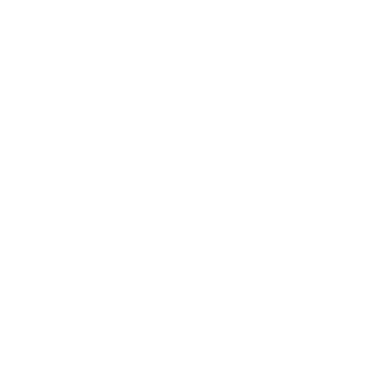

In [26]:
result_vqe.raw_result.optimal_circuit.decompose().decompose().decompose().draw('mpl')

In [ ]:
result_vqe.raw_result.optimal_circuit.decompose().decompose().decompose().depth()

In [ ]:
result_vqe.raw_result.optimal_circuit.decompose().decompose().decompose().count_ops()

In [27]:
print(f"result vqe: depth = {result_vqe.raw_result.optimal_circuit.decompose().decompose().decompose().depth()}, size = { result_vqe.raw_result.optimal_circuit.decompose().decompose().decompose().size()}, gates = {result_vqe.raw_result.optimal_circuit.decompose().decompose().decompose().count_ops()}")

result vqe: depth = 10315, size = 16196, gates = OrderedDict([('cx', 8064), ('h', 4992), ('sdg', 1248), ('s', 1248), ('rz', 640), ('u', 4)])


In [28]:
print(f"result adapt_vqe: depth = {result_adapt.raw_result.optimal_circuit.decompose().decompose().decompose().depth()}, size = { result_adapt.raw_result.optimal_circuit.decompose().decompose().decompose().size()}, gates = {result_adapt.raw_result.optimal_circuit.decompose().decompose().decompose().count_ops()}")

result adapt_vqe: depth = 1765, size = 2716, gates = OrderedDict([('cx', 1360), ('h', 832), ('sdg', 208), ('s', 208), ('rz', 104), ('u', 4)])


In [29]:
print(f"result state_vqe: depth = {result_state.raw_result.optimal_circuit.decompose().decompose().decompose().depth()}, size = { result_state.raw_result.optimal_circuit.decompose().decompose().decompose().size()}, gates = {result_state.raw_result.optimal_circuit.decompose().decompose().decompose().count_ops()}")

result state_vqe: depth = 10315, size = 16196, gates = OrderedDict([('cx', 8064), ('h', 4992), ('sdg', 1248), ('s', 1248), ('rz', 640), ('u', 4)])


In [30]:
print(f"result state_adapt_vqe: depth = {result_adapt_state.raw_result.optimal_circuit.decompose().decompose().decompose().depth()}, size = { result_adapt_state.raw_result.optimal_circuit.decompose().decompose().decompose().size()}, gates = {result_adapt_state.raw_result.optimal_circuit.decompose().decompose().decompose().count_ops()}")

result state_adapt_vqe: depth = 1765, size = 2716, gates = OrderedDict([('cx', 1360), ('h', 832), ('sdg', 208), ('s', 208), ('rz', 104), ('u', 4)])
